In [22]:
##############################
# Import Modules
##############################

import numpy as np
import pandas
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os, csv
import pprint

In [2]:
##############################
# Suppress Warnings Settings and Display Settings
##############################

# suppress warnings completely
warnings.filterwarnings('ignore')

# suppress warnings after seen once
# warnings.filterwarnings(action='once')

# pretty print settings
pp = pprint.PrettyPrinter(indent=4)

# dataframe display settings
pandas.options.display.max_columns = None

# Data Ingest

In [3]:
##############################
# Import Dataset
#
# Encodings:
# Sex= M=1, F=2
# Renal disease: Diabetes=1, Renovasculardisease=2, others=3, uncertain=4, All types of nephritis=5
# Withdrawal= Yes=1, No=2
# All comorbidities from column F to U= Yes = 1, No = 2
# Modality= HD=1, PD=2
##############################

# import dataset from csv
dataframe = pandas.read_csv('dataset/diabetic_data_initial.csv', engine='python')

# seperate male
male_dataframe = dataframe.loc[dataframe['gender'] == 'Male']

# seperate female
female_dataframe = dataframe.loc[dataframe['gender'] == 'Female']

# seperate other
other_dataframe = dataframe.loc[dataframe['gender'] == 'Unknown/Invalid']

# select dataframe to use [dataframe, male_dataframe, female_dataframe]
use_dataframe = dataframe


In [4]:
##############################
# Data Preprocessing (Step 1)
#        Shuffle Data Set
#        Remove Irrelevant Columns
#        Convert Categorical Feature to Binary
#        Seperate features from targets
##############################

# shuffle data set
def shuffle(df):
    return df.sample(frac=1).reset_index(drop=True)

# drop columns with specified label
def dropColumn(df, colLabels):
    for colLabel in colLabels:
        if colLabel in df.columns:
            df.drop([colLabel], axis=1, inplace=True)
    return df

# convert feature from categorical to binary
def categoricalToBinary(df, colLabel):
    if colLabel in df.columns:
        df = pandas.get_dummies(df, columns=[colLabel])
    return df

# return features (X) and target (Y) from dataframe
def seperateDataTargets(df, targetLabel):
    X = df.drop(targetLabel, axis=1).values
    Y = df[targetLabel].values.ravel()
    return X, Y

# convert to binary classes: 1 (positive) or 0 (negative)
def convertToBinaryClass(y):
    for i in range(len(y)):
        if y[i] != 1:
            y[i] = 0
        else:
            y[i] = 1
    return np.array(y)

target_name = 'readmitted'
use_dataframe = shuffle(use_dataframe)
use_dataframe = dropColumn(use_dataframe, ['encounter_id', 'patient_nbr'])


In [5]:
# display top rows of data set
# renameTo = {'kidney disease_1': 'kidney disease_Diabetes', 
#             'kidney disease_2': 'kidney disease_Renovasculardisease', 
#             'kidney disease_3': 'kidney disease_Others',
#             'kidney disease_4': 'kidney disease_Uncertain', 
#             'kidney disease_5':'kidney disease_All Types of Nephritis'}
# use_dataframe.rename(columns = renameTo, inplace = True)
use_dataframe.head(5)

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Male,[60-70),?,2,3,4,6,HM,Family/GeneralPractice,65,6,40,0,0,0,410,250.51,250.81,9,None,None,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
1,Caucasian,Female,[90-100),?,1,22,7,2,MC,?,51,1,13,0,0,0,276,585,496,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
2,Other,Male,[30-40),?,5,1,17,8,MD,?,13,0,27,1,2,1,780,577,250.4,9,>300,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
3,AfricanAmerican,Female,[40-50),?,1,18,7,4,?,Family/GeneralPractice,41,0,11,0,0,0,428,493,780,8,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
4,Caucasian,Male,[70-80),?,2,1,7,5,MC,Emergency/Trauma,28,0,22,0,0,2,428,799,427,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30


In [6]:
# display some statistics of data set
use_dataframe.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [7]:
##############################
# Data Preprocessing (Step 2)
#        Set Types for Columns
#        Find and Replace Terms
#        Impute values for NaN
##############################

# set date type for Birthdate, Deathdate
# use_dataframe['BIRTHDATE'] = pandas.to_datetime(use_dataframe['BIRTHDATE'])
# use_dataframe['DEATHDATE'] = pandas.to_datetime(use_dataframe['DEATHDATE'])

# find and replace Unknown
use_dataframe.replace('?',np.NaN,inplace=True)

# print rows that have at least 1 missing value
# use_dataframe[use_dataframe.isnull().any(axis=1)]


In [8]:
##############################
# Data Preprocessing (Step 3)
#        Change type to Category
#        Label Encoding
#        One-Hot Encoding
##############################

# change object type to category type
obj_to_category_list = use_dataframe.select_dtypes(include=['object']).columns.tolist()

for obj in obj_to_category_list:
    use_dataframe[obj] = use_dataframe[obj].astype('category')


# save label encodings to le_dict
le_dict = {}
cols_for_le = obj_to_category_list

for col in cols_for_le:
    le_dict[col] = dict(enumerate(use_dataframe[col].cat.categories))


# label encoding
for col in cols_for_le:
    use_dataframe[col] = use_dataframe[col].cat.codes


# one hot encoding
# cols_for_he = ['RACE','ETHNICITY','Molecular_Profile','Mutation','Drugs','Type'] # removed 'BIRTHPLACE'
# use_dataframe = pandas.get_dummies(use_dataframe, columns=cols_for_he, dummy_na=True)


# convert boolean classes to int (0 - False, 1 - True)
# use_dataframe['Diabetic'] = use_dataframe['Diabetic'].astype(int)
# use_dataframe['Hypertension'] = use_dataframe['Hypertension'].astype(int)


# seperate X, Y and binarize outcome Y
X, Y = seperateDataTargets(use_dataframe, [target_name])

In [9]:
# label encoding dictionary
pp.pprint(le_dict)

{   'A1Cresult': {0: '>7', 1: '>8', 2: 'None', 3: 'Norm'},
    'acarbose': {0: 'Down', 1: 'No', 2: 'Steady', 3: 'Up'},
    'acetohexamide': {0: 'No', 1: 'Steady'},
    'age': {   0: '[0-10)',
               1: '[10-20)',
               2: '[20-30)',
               3: '[30-40)',
               4: '[40-50)',
               5: '[50-60)',
               6: '[60-70)',
               7: '[70-80)',
               8: '[80-90)',
               9: '[90-100)'},
    'change': {0: 'Ch', 1: 'No'},
    'chlorpropamide': {0: 'Down', 1: 'No', 2: 'Steady', 3: 'Up'},
    'citoglipton': {0: 'No'},
    'diabetesMed': {0: 'No', 1: 'Yes'},
    'diag_1': {   0: '10',
                  1: '11',
                  2: '110',
                  3: '112',
                  4: '114',
                  5: '115',
                  6: '117',
                  7: '131',
                  8: '133',
                  9: '135',
                  10: '136',
                  11: '141',
                  12: '142',
          

In [10]:
# display top rows of data set after preprocessing
use_dataframe.head(10)

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2,1,6,-1,2,3,4,6,6,11,65,6,40,0,0,0,259,99,111,9,2,2,2,1,1,1,1,0,1,0,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,2
1,2,0,9,-1,1,22,7,2,7,-1,51,1,13,0,0,0,143,386,326,9,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,2
2,4,1,3,-1,5,1,17,8,8,-1,13,0,27,1,2,1,534,379,100,9,1,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,0
3,0,0,4,-1,1,18,7,4,-1,11,41,0,11,0,0,0,276,315,529,8,2,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1
4,2,1,7,-1,2,1,7,5,7,8,28,0,22,0,0,2,276,528,267,9,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,0
5,2,1,6,-1,1,1,7,1,7,11,20,0,13,0,0,0,360,509,256,9,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,2,1,0,0,0,0,1,1,2
6,3,0,5,-1,1,18,7,2,-1,-1,48,0,16,0,0,2,540,261,246,9,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1
7,2,1,5,-1,1,1,7,8,7,-1,77,2,37,0,1,1,394,260,88,9,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0
8,4,0,7,-1,3,1,1,11,-1,18,18,4,9,1,0,1,708,271,407,6,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1
9,2,0,3,-1,6,25,1,4,-1,24,46,3,16,0,0,0,454,423,107,9,2,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,2


In [11]:
# display statistics of data set (for categorical vars use include='all')
use_dataframe.describe(include='all')

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.0,101766.0,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.598776,0.462443,6.096702,-0.777195,2.024006,3.715642,5.754437,4.395987,3.885581,10.708871,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,336.704164,275.484415,276.899377,7.422607,1.983914,1.893383,1.195596,1.015319,1.006928,1.000884,1.050410,0.000010,1.121219,1.101547,0.000226,1.071989,1.062585,1.003066,1.000295,0.000029,0.000393,0.0,0.0,1.405469,1.006898,0.000128,0.000010,0.000020,0.000010,0.538048,0.770031,1.427520
std,0.938415,0.498649,1.594084,1.310364,1.445403,5.280166,4.064081,2.985108,4.823023,17.507131,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,160.602618,153.514277,177.751761,1.933600,0.309922,0.517917,0.435442,0.134652,0.086992,0.031956,0.241057,0.003135,0.364232,0.343916,0.015032,0.271523,0.252738,0.057550,0.020791,0.005429,0.020312,0.0,0.0,0.838798,0.084414,0.011302,0.003135,0.004433,0.003135,0.498553,0.420815,0.684068
min,-1.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,5.000000,-1.000000,1.000000,1.000000,1.000000,2.000000,-1.000000,-1.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,259.000000,142.000000,139.000000,6.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,2.000000,0.000000,6.000000,-1.000000,1.000000,1.000000,7.000000,4.000000,6.000000,3.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,298.000000,260.000000,255.000000,8.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
75%,2.000000,1.000000,7.000000,-1.000000,3.000000,4.000000,7.000000,6.000000,7.000000,18.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,435.000000,373.000000,359.750000,9.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
max,4.000000,2.000000,9.000000,8.000000,8.000000,28.000000,25.000000,14.00000

In [12]:
# display dataset feature types
use_dataframe.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
race                        101766 non-null int8
gender                      101766 non-null int8
age                         101766 non-null int8
weight                      101766 non-null int8
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null int8
medical_specialty           101766 non-null int8
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null int16
diag_2                      101766 non-null i

In [13]:
##############################
# Data Set Characteristics
#        Store Data Set Characteristics
##############################

# feature names and class names
feature_names = use_dataframe.drop([target_name, 'encounter_id', 'patient_nbr'], axis=1, errors='ignore').columns.tolist()
class_names = ['>30', '<30', 'NO'] # >30 readmission, <30 days readmission, No readmission

# number of rows and columns
num_cols = use_dataframe.shape[1]
num_rows = use_dataframe.shape[0]

# print basic data set characteristics
print('\n'.join(feature_names))
print("\nNumber of Rows: " + str(num_rows))
print("Number of Cols: " + str(num_cols))

race
gender
age
weight
admission_type_id
discharge_disposition_id
admission_source_id
time_in_hospital
payer_code
medical_specialty
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
diag_1
diag_2
diag_3
number_diagnoses
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed

Number of Rows: 101766
Number of Cols: 48


In [14]:
##############################
# Classifiers and Parameters:
#        Dictionary of Classifiers & Parameters for Grid Search
##############################

classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'kNN': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Gaussian Process': GaussianProcessClassifier(n_jobs=-1),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Ada Boost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier()
}

clf_params = {
    'Decision Tree': 
        {
            'clf__criterion': ["gini", "entropy"],
            'clf__class_weight': ["balanced", {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:40}, {0:1, 1:80}, {0:1, 1:160}],
            'clf__max_depth': [3, 5, 7, 10, None],
            'clf__max_features': ["auto", "log2"],
            'clf__max_leaf_nodes': [35, 37, 39, 41, 43, None],
            'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
            'clf__min_samples_leaf': [0.04, 0.06, 0.08, 0.1, 0.2, 1]            
        },
    'kNN': 
        {
            'clf__n_neighbors': np.arange(1, 30),
            'clf__p': np.arange(1, 6)
        },
    'Gaussian Naive Bayes': {}, # no hyperparameters
    'Bernoulli Naive Bayes': {}, # requires: binarize all features
    'Gaussian Process': 
        {
            'clf__kernel': [None, Matern()],
            'clf__optimizer': ["fmin_l_bfgs_b"],
            'clf__n_restarts_optimizer': np.arange(0, 10)
        },
    'SVM': 
        {
            'clf__kernel': ["linear", "poly", "rbf", "sigmoid"],
            'clf__C': [0.1, 1, 10, 100],
            'clf__gamma': [0.1, 1, 10, 100],
            'clf__degree': np.arange(0, 7),
            'clf__class_weight': ["balanced", {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:40}, {0:1, 1:80}, {0:1, 1:160}]
        },
    'Random Forest': 
        {
            'clf__n_estimators': [1, 8, 12, 16, 18, 20, 22, 24, 26],
            'clf__max_depth': [3, 5, 7, 10, 12, None],
            'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
            'clf__min_samples_leaf': [0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 1],
            'clf__max_features': ["auto", "log2", None],
            'clf__class_weight': ["balanced", {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:40}, {0:1, 1:80}, {0:1, 1:160}]
        },
    'Ada Boost': 
        {
            'clf__base_estimator': [DecisionTreeClassifier(criterion="entropy",
                                                           max_depth=7,
                                                           min_samples_split=0.6,
                                                           min_samples_leaf=1,
                                                           max_features='auto',
                                                           max_leaf_nodes=35,
                                                           class_weight={0:1, 1:9})], # need to find best dt models and input them here
            'clf__n_estimators': [1, 2, 3, 8, 16, 32, 64, 100, 200],
            'clf__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'clf__class_weight': ["balanced", {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:40}, {0:1, 1:80}, {0:1, 1:160}],
        },
    'Gradient Boosting': 
        {
            'clf__learning_rate': [1, 0.5],
            'clf__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100],
            'clf__max_depth': np.append(range(1,20), None),
            'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
            'clf__min_samples_leaf': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 1],
            'clf__max_features': ["auto", "log2", None]
        },
    'MLP': 
        {
            'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'clf__activation': ['logistic', 'tanh', 'relu'],
            'clf__solver': ['lbfgs', 'sgd', 'adam'],
            'clf__alpha': [0.0001, 0.001, 0.05, 0.01],
            'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
        }
}

feature_select_params = {}

feature_transform_params = {}

In [15]:
##############################
# Build Pipeline
# 
# 1. Feature Selection
# 2. Feature Transformation
# 3. Classifiers
##############################

pipelines = {}

# 1. Feature Selection
feature_select = SelectKBest()

# 2. Feature Transformation
feature_scale = StandardScaler(copy=True, with_mean=True, with_std=True)
feature_transform = PCA() # classifiers perform worse with linear PCA

for key, clf in classifiers.items():
    pipelines[key] = Pipeline([
#         ('feature_select', feature_select),
        ('feature_scale', feature_scale),
#         ('feature_transform', feature_transform),
        ('clf', clf)
    ])

In [16]:
# pipeline test code
# pipelines['Decision Tree'].get_params()

In [17]:
##############################
# Custom Scoring Function
#        Specificity
##############################

def specificity_score(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return tn / (tn + fp)

specificity = make_scorer(specificity_score, greater_is_better=True)


In [24]:
%%time
##############################
# Grid Search
##############################

scoring = {'f1': 'f1_macro', 
           'recall': 'recall_macro',
           'precision': 'precision_macro',
#            'auc': 'roc_auc',
           'accuracy': 'accuracy',
#            'specificity': specificity
          }

primary_metric = 'recall'

# make grid search object with pipeline and param grid
def makeGridSearchObj(pipeline, params):
    grid_search = GridSearchCV(pipeline, 
                               params, 
                               cv=KFold(10), 
                               scoring=scoring,
                               refit=primary_metric,
                               return_train_score=False,
                               n_jobs=-1)
    return grid_search


# execute grid search
clf_name = 'Gaussian Naive Bayes'
grid_search = makeGridSearchObj(pipelines[clf_name], 
                                clf_params[clf_name])
grid_search.fit(X, Y)

Wall time: 2.64 s


In [25]:
##############################
# Display Summary of Grid Search
##############################

result = grid_search.cv_results_
best_index = grid_search.best_index_

print("BEST PARAMS ({}):".format(primary_metric))
pp.pprint(grid_search.best_params_)

print("\nBEST MODEL RESULTS ({}):".format(primary_metric))
for metric in scoring:
    print("{0:16} {1:.3f} (+/-{2:.3f})".format(
        metric,
        result['mean_test_{}'.format(metric)][best_index], 
        result['std_test_{}'.format(metric)][best_index]))

print("\nACROSS ALL MODELS:")
for metric in scoring:
    test_scores = result['mean_test_{}'.format(metric)]
    print(metric)
    print("\tmean\t {0:.3f} (+/-{1:.3f})".format(np.mean(test_scores), np.std(test_scores, ddof=1)))
    print("\tmin\t {:.3f}".format(np.min(test_scores)))
    print("\tmax\t {:.3f}".format(np.max(test_scores)))

BEST PARAMS (recall):
{}

BEST MODEL RESULTS (recall):
f1               0.072 (+/-0.002)
recall           0.335 (+/-0.001)
precision        0.439 (+/-0.060)
accuracy         0.114 (+/-0.003)

ACROSS ALL MODELS:
f1
	mean	 0.072 (+/-nan)
	min	 0.072
	max	 0.072
recall
	mean	 0.335 (+/-nan)
	min	 0.335
	max	 0.335
precision
	mean	 0.439 (+/-nan)
	min	 0.439
	max	 0.439
accuracy
	mean	 0.114 (+/-nan)
	min	 0.114
	max	 0.114


In [23]:
##############################
# Classifier Refit on Best Model
##############################
best_clf = grid_search.best_estimator_
cv_results = cross_validate(best_clf, X, Y, 
                            cv=KFold(10), 
                            return_train_score=False,
                            scoring=['recall_macro'])

for k, v in cv_results.items():
    if "time" not in k:
        print("{0:22} {1:.3f} (+/-{2:.3f})".format(k, np.mean(v), np.std(v, ddof=1)))


test_recall_macro      0.335 (+/-0.001)


In [13]:
# tuned classifiers for testing

clf = DecisionTreeClassifier(criterion="entropy",
                             max_depth=10,
                             min_samples_split=0.1,
                             min_samples_leaf=1,
                             max_features='auto',
                             max_leaf_nodes=35,
                             class_weight={0:1, 1:10})

clfs = {
    'Decision Tree': DecisionTreeClassifier(criterion="entropy",
                             max_depth=10,
                             min_samples_split=0.1,
                             min_samples_leaf=1,
                             max_features='auto',
                             max_leaf_nodes=35,
                             class_weight={0:1, 1:10}),
    'kNN': KNeighborsClassifier(n_neighbors=1, p=5),
    'Gaussian Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(criterion="entropy",
                             max_depth=7,
                             min_samples_split=0.1,
                             min_samples_leaf=0.2,
                             max_features='auto',
                             n_estimators=8,
                             class_weight={0:1, 1:10}),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.5,
                             max_depth=16,
                             min_samples_split=0.4,
                             min_samples_leaf=0.03,
                             max_features='log2',
                             n_estimators=4),
    
#     'SVM': SVC(C=0.1,
#              degree=1,
#              gamma=0.1,
#              kernel='poly',
#              probability=True,
#              class_weight={0:1, 1:10})
}

In [77]:
##############################
# Single Classifier Fit and Results
##############################

scoring = {'f1': 'f1_macro', 
           'recall': 'recall_macro',
           'precision': 'precision_macro',
#            'auc': 'roc_auc',
           'accuracy': 'accuracy',
#            'specificity': specificity
          }

use_clf = GradientBoostingClassifier()
cv_results = cross_validate(use_clf, X, Y,
                            cv=StratifiedKFold(10), 
                            return_train_score=False,
                            scoring=scoring)

print("PARAMS:")
pp.pprint(use_clf.get_params())

print("\nMODEL RESULTS:")
for k, v in cv_results.items():
    if "time" not in k:
        print("{0:22} {1:.3f} (+/-{2:.3f})".format(k, np.mean(v), np.std(v, ddof=1)))


PARAMS:
{   'criterion': 'friedman_mse',
    'init': None,
    'learning_rate': 0.1,
    'loss': 'deviance',
    'max_depth': 3,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_impurity_split': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_iter_no_change': None,
    'presort': 'auto',
    'random_state': None,
    'subsample': 1.0,
    'tol': 0.0001,
    'validation_fraction': 0.1,
    'verbose': 0,
    'warm_start': False}

MODEL RESULTS:
test_f1                0.395 (+/-0.004)
test_recall            0.413 (+/-0.002)
test_precision         0.543 (+/-0.025)
test_accuracy          0.590 (+/-0.002)


In [27]:
##############################
# Feature Selection Example: 
#        ANOVA
#        Mutual Information
##############################

# set base parameters
anova_params = {'score_func': f_classif, 'k': 10}
mi_params = {'score_func': mutual_info_classif, 'k': 10}

# select K best features
feature_select = SelectKBest()


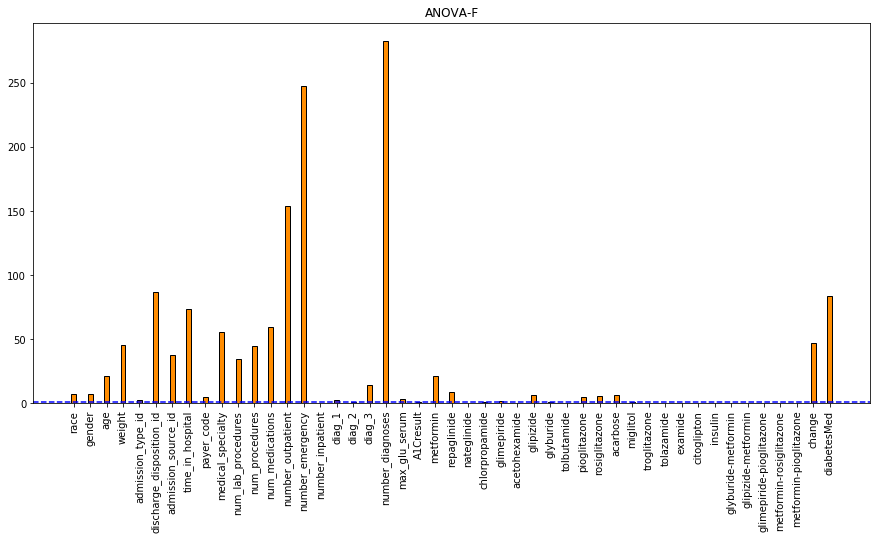

In [28]:
##############################
# Visualize Feature Scores
##############################

# anova feature score calculation
anova_select = feature_select.set_params(**anova_params)
anova_select.fit(X, Y)
scores = -np.log10(anova_select.pvalues_)
# scores /= np.max(scores)


# mi feature score calculation
mi_select = feature_select.set_params(**mi_params)
mi_select.fit(X, Y)
mi = mi_select.scores_
mi /= np.max(mi)


# visualize feature scores - anova
fig, ax = plt.subplots(figsize=(15, 7))
ind = np.arange(len(scores))

plt_anova = plt.bar(ind, scores, width=.3, color='darkorange', edgecolor='black')

ax.set_xticklabels(feature_names)
ax.axhline(-np.log10(0.05), ls='--', color='blue')
plt.xticks(ind, rotation=90)
plt.title('ANOVA-F')
plt.show()


# does not work well with this dataset
# visualize feature scores - mutual information
# fig, ax = plt.subplots(figsize=(15, 7))

# plt_mi = plt.bar(ind, mi, width=.3, color='lightgreen', edgecolor='black')

# ax.set_xticklabels(feature_names)
# plt.xticks(ind, rotation=90)
# plt.title('Mutual Information')
# plt.show()


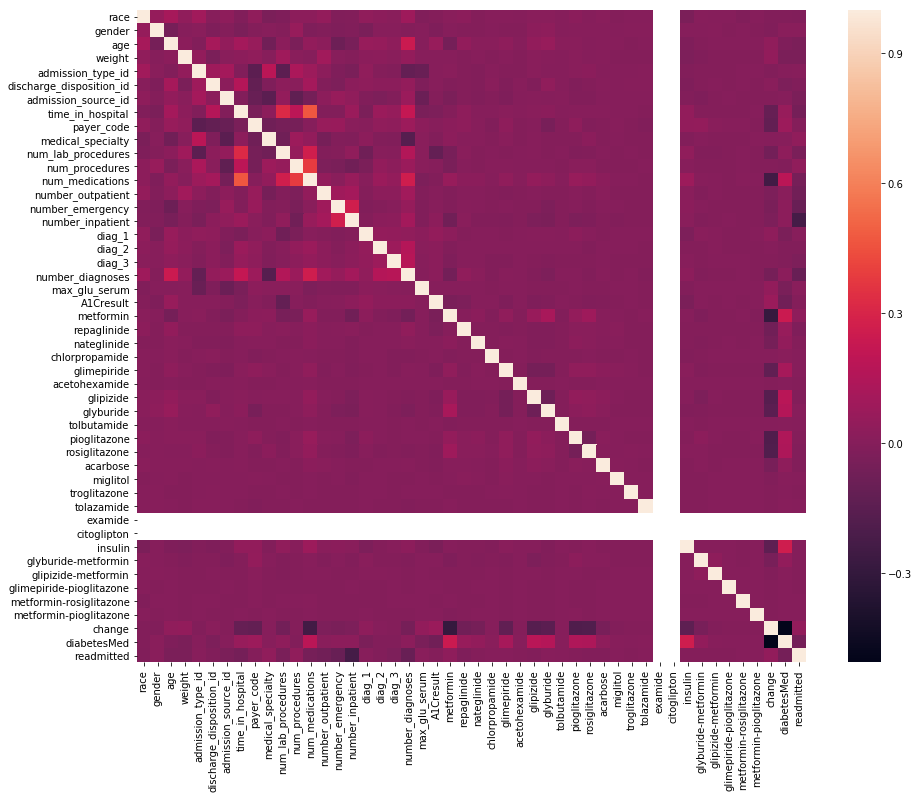

race                       -0.015184
gender                      0.014533
age                        -0.030271
weight                     -0.031107
admission_type_id           0.008950
discharge_disposition_id   -0.012450
admission_source_id        -0.031816
time_in_hospital           -0.057718
payer_code                 -0.005635
medical_specialty           0.040584
num_lab_procedures         -0.037976
num_procedures              0.038235
num_medications            -0.051772
number_outpatient          -0.068552
number_emergency           -0.103024
number_inpatient           -0.234283
diag_1                      0.010474
diag_2                     -0.006813
diag_3                     -0.024444
number_diagnoses           -0.104820
max_glu_serum               0.012554
A1Cresult                  -0.003312
metformin                   0.031149
repaglinide                -0.019256
nateglinide                -0.003039
chlorpropamide              0.001134
glimepiride                 0.001777
a

In [29]:
##############################
# Visualize Dataset Characteristics: 
#        Correlation Matrix
##############################

# calculate the correlation matrix
corr = use_dataframe.corr()

# plot the correlation heatmap
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

print(corr['readmitted'])

In [ ]:
##############################
# Dataset Visualizations: 
#        tSNE
##############################

# iterate on perplexity
perplexity = [1, 2, 5, 30, 50, 100]

# apply standard scaler to X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for p in perplexity:
    # apply tSNE
    tsne = TSNE(n_components=2, perplexity=p, n_iter=5000, learning_rate=10)
    tsne_transformed = tsne.fit_transform(X_scaled)

    # display results from tSNE
    plt.subplots(figsize=(15, 12))
    plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=Y, cmap='prism', alpha=1)
    plt.xticks(rotation=90)
    plt.title("TSNE - Perplexity: {}".format(tsne.get_params()['perplexity']))
    plt.show()


In [20]:
##############################
# Feature Transformation Example: 
#        Standard Scalar
#        PCA
#        NMF
#        Kernel PCA
##############################

# transform functions
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
pca = PCA()
nmf = NMF()
kpca = KernelPCA()


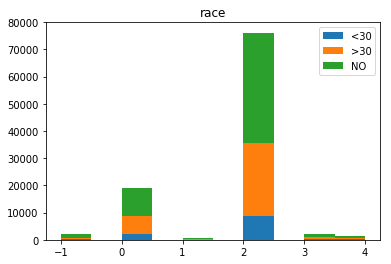

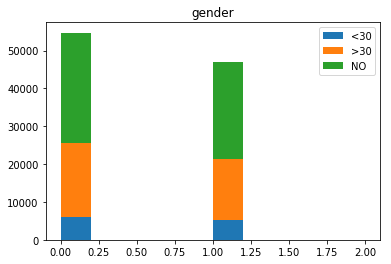

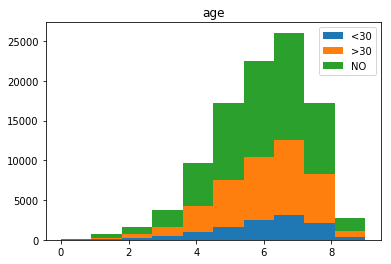

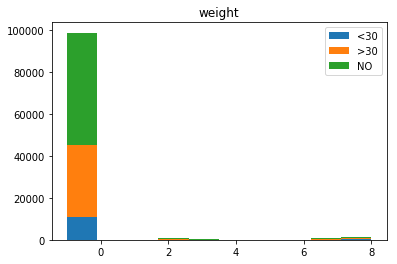

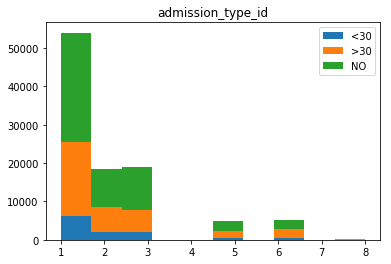

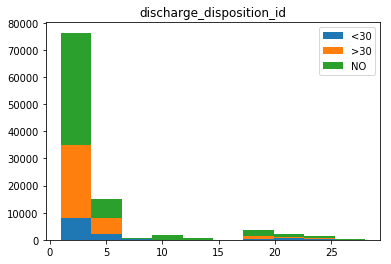

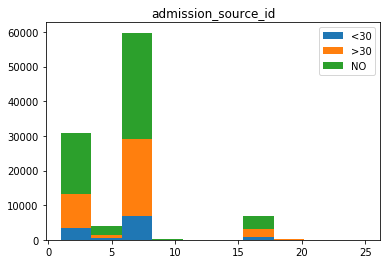

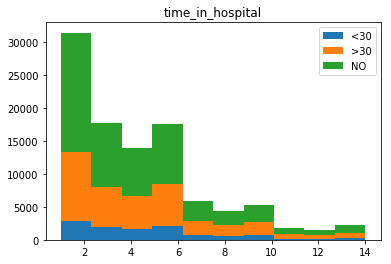

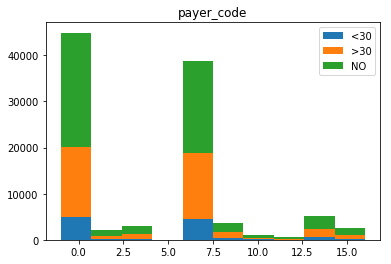

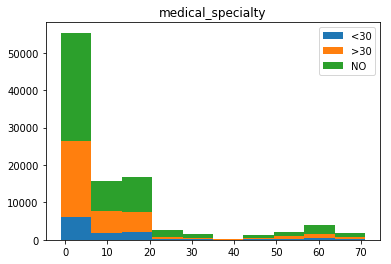

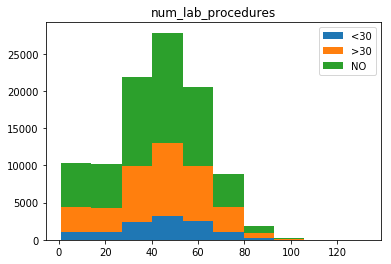

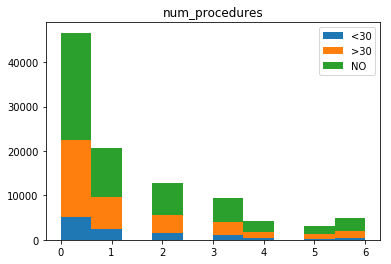

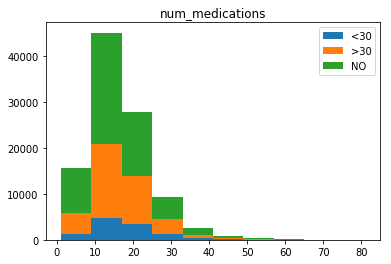

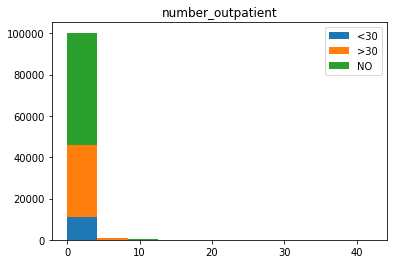

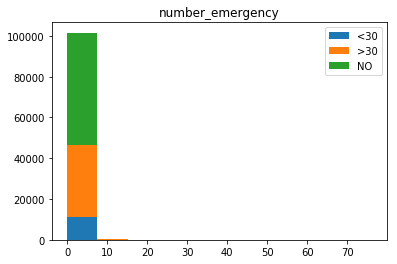

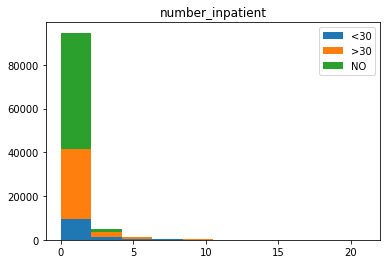

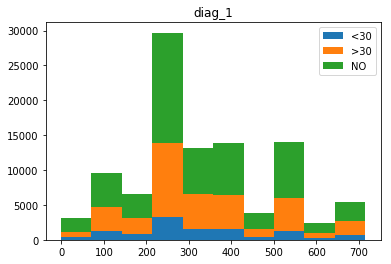

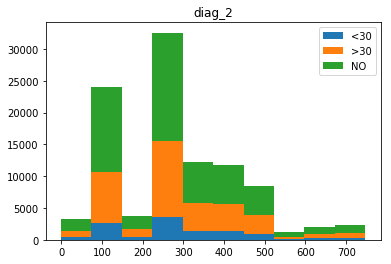

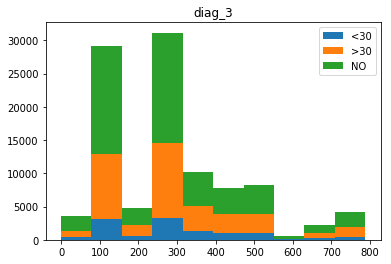

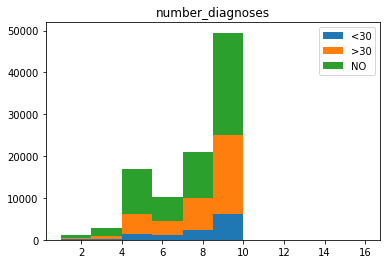

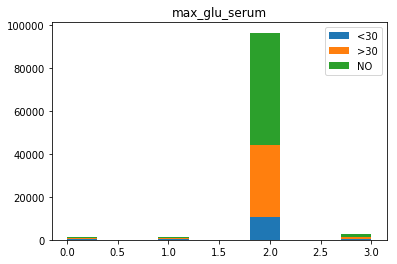

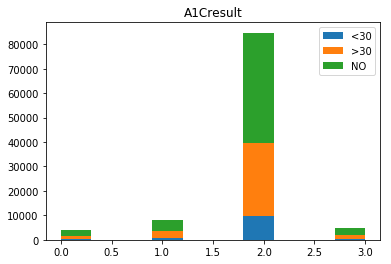

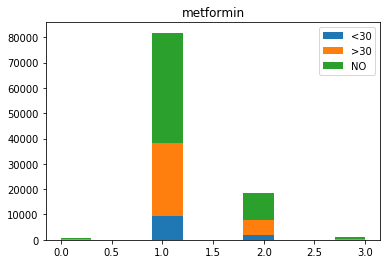

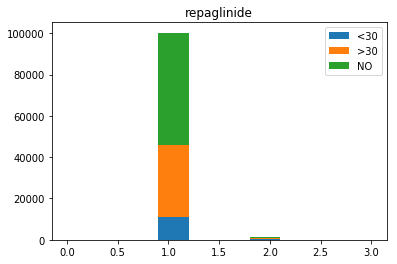

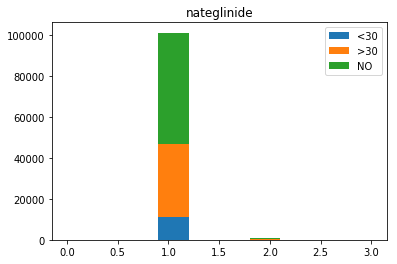

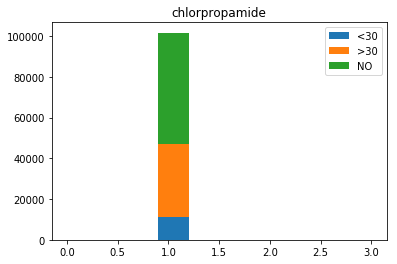

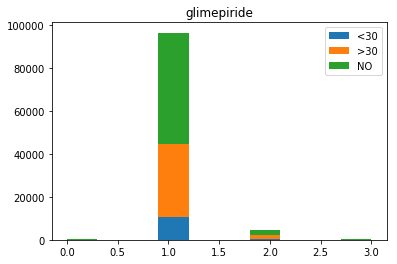

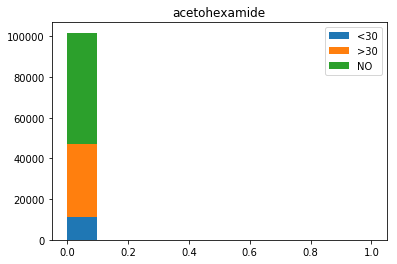

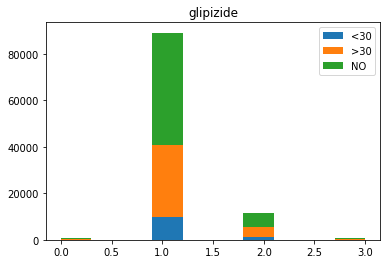

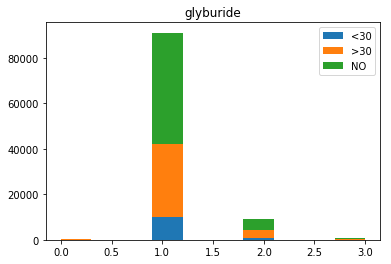

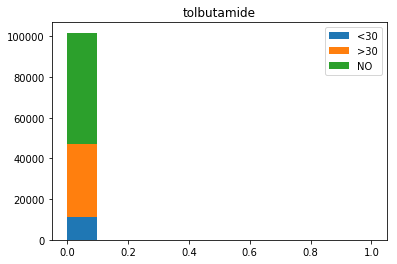

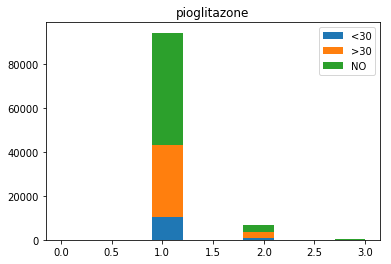

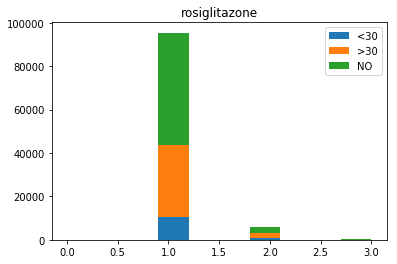

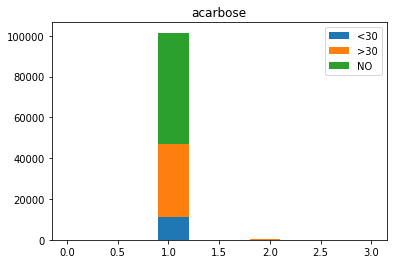

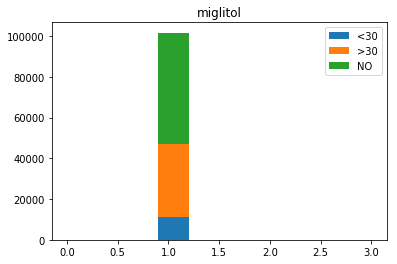

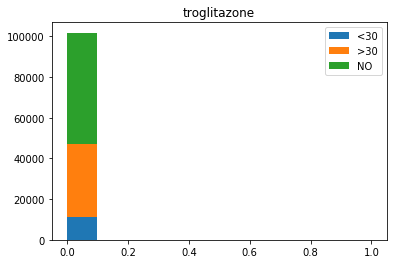

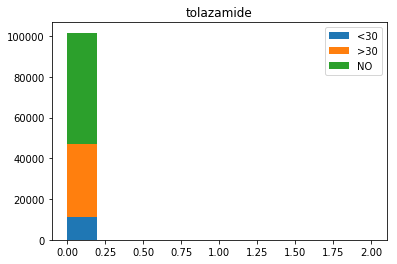

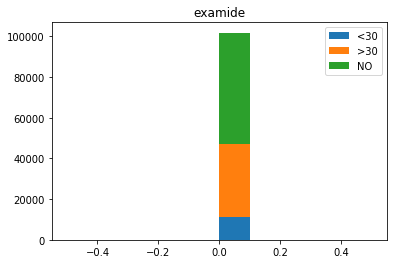

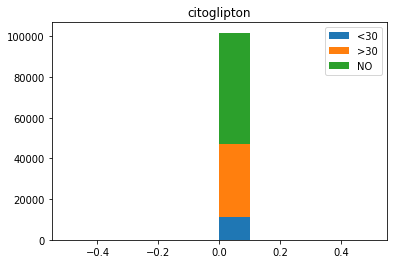

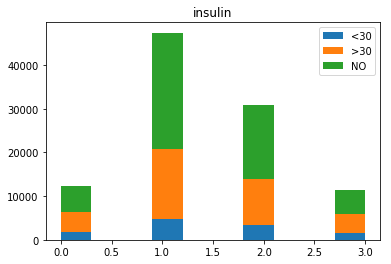

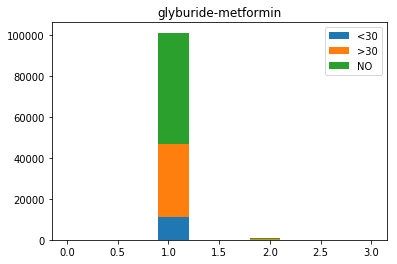

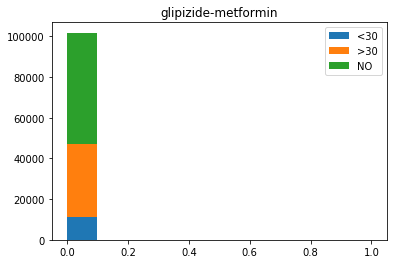

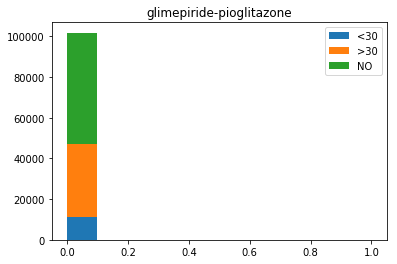

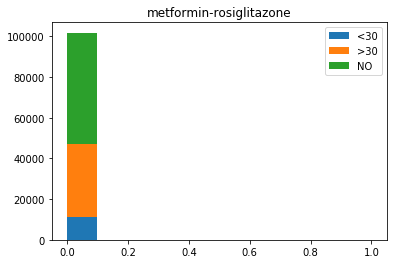

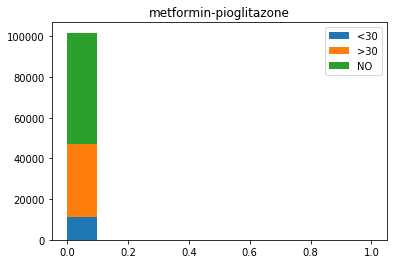

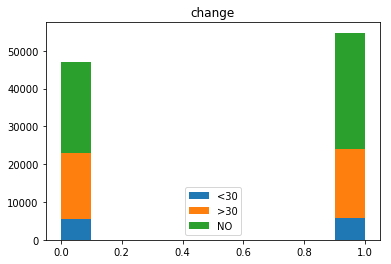

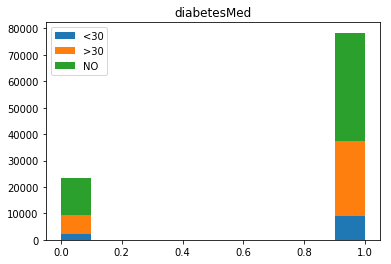

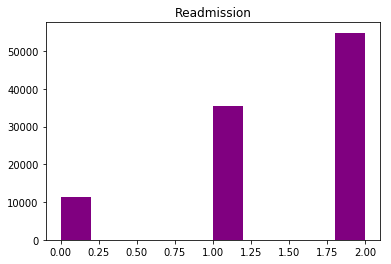

In [80]:
# display features distributions by target
ind_0 = np.where(Y == 0)[0]
ind_1 = np.where(Y == 1)[0]
ind_2 = np.where(Y == 2)[0]

# plot each feature with target distribution
for i in range(0, len(feature_names)):
    plt.subplots()
#     plt.hist(X[:,i])
#     plt.scatter(X[:,i], Y)
    plt_data = np.array([X[:,i][ind_0], X[:,i][ind_1], X[:,i][ind_2]])
    plt.hist(plt_data, histtype='bar', stacked=True, label=['<30', '>30', 'NO'])
    plt.legend()
    plt.title("{}".format(feature_names[i]))
    plt.show()
    
# display target distribution
plt.subplots()
plt.hist(Y, color='purple')
plt.title("Readmission")
plt.show()

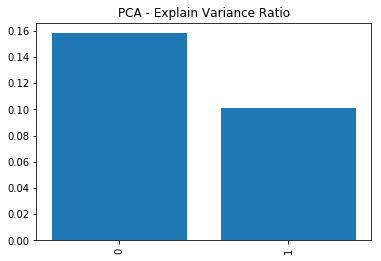

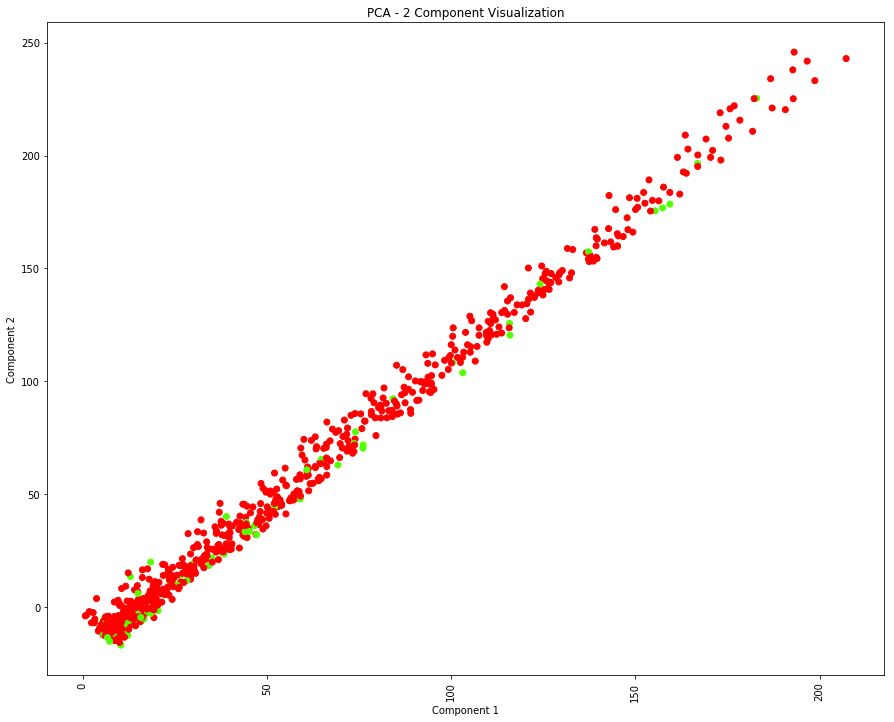

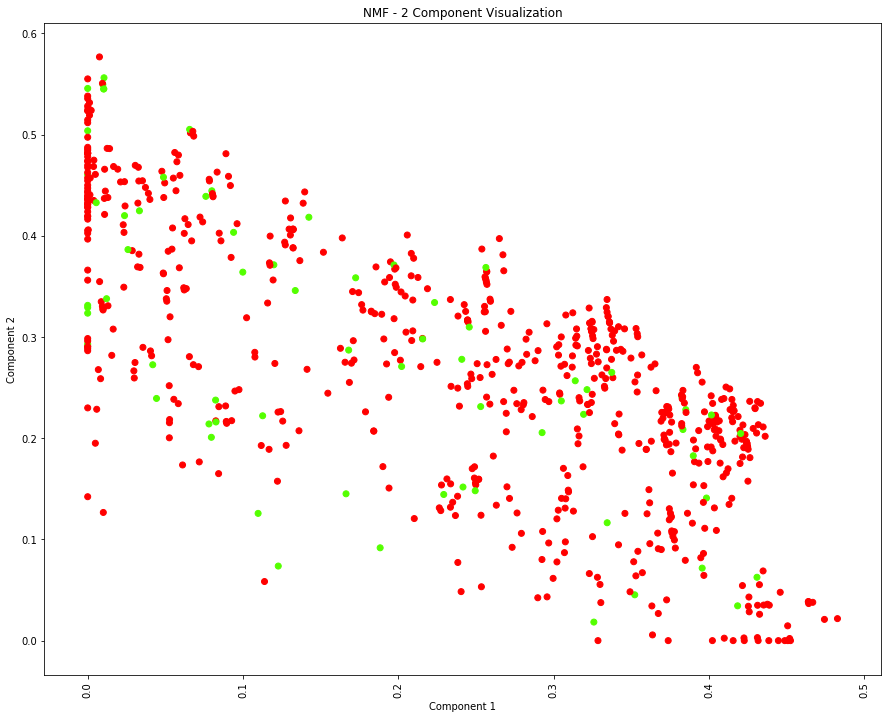

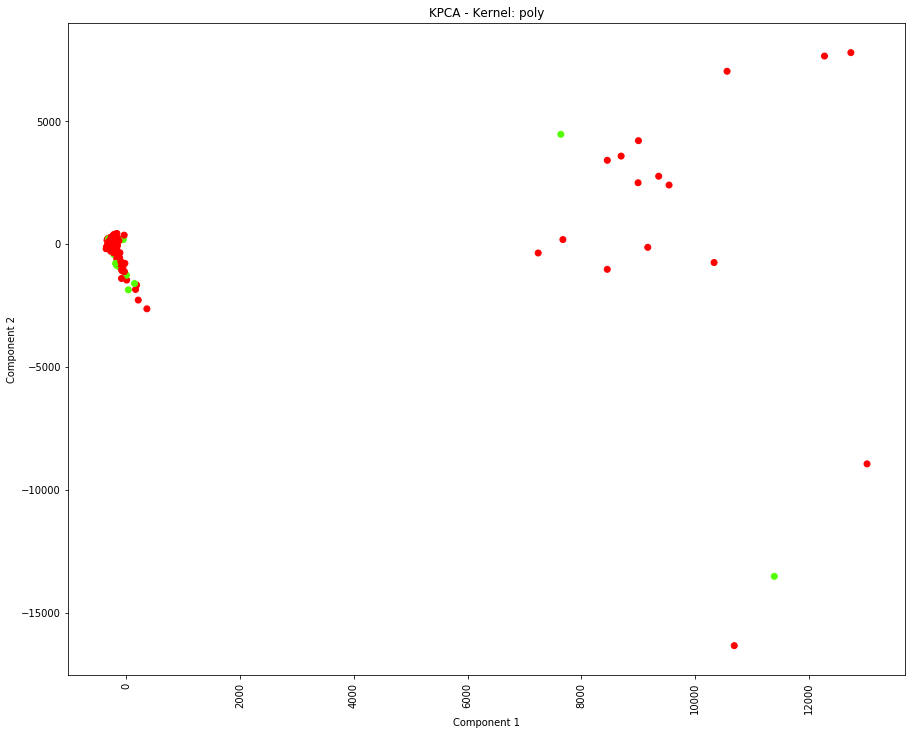

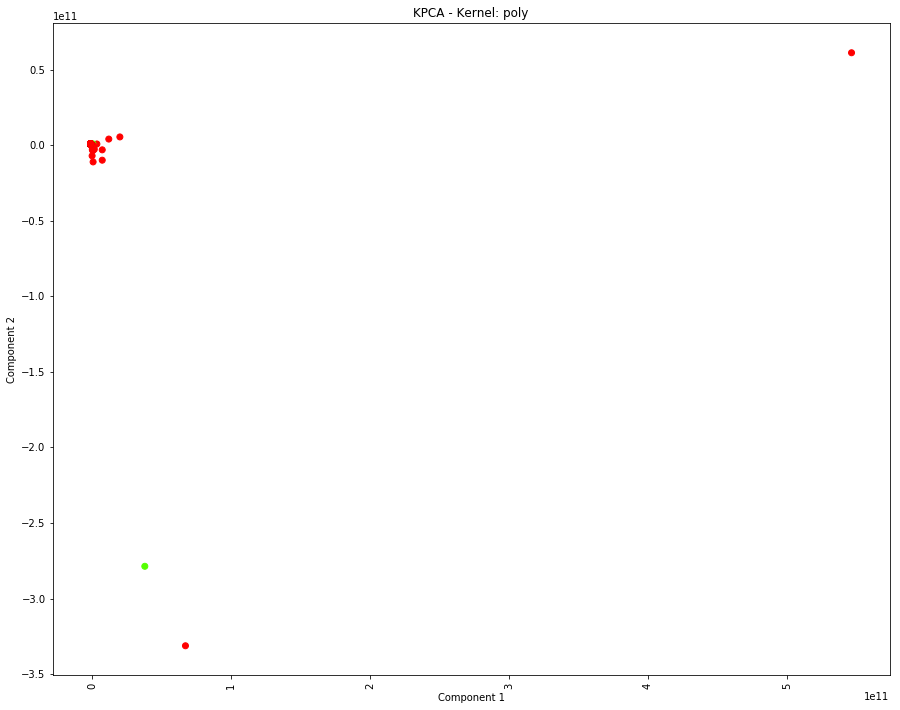

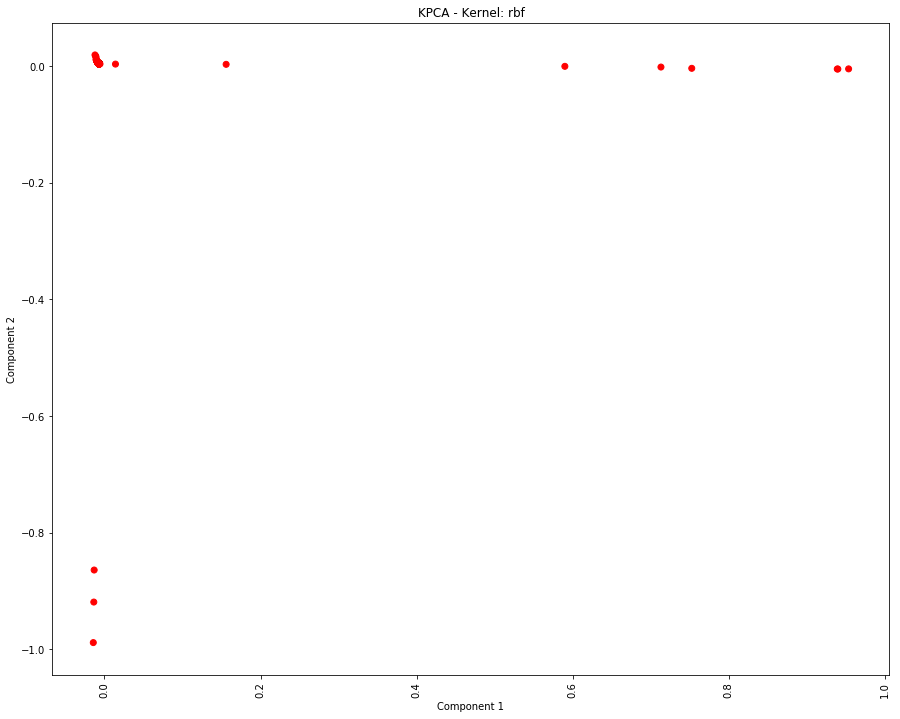

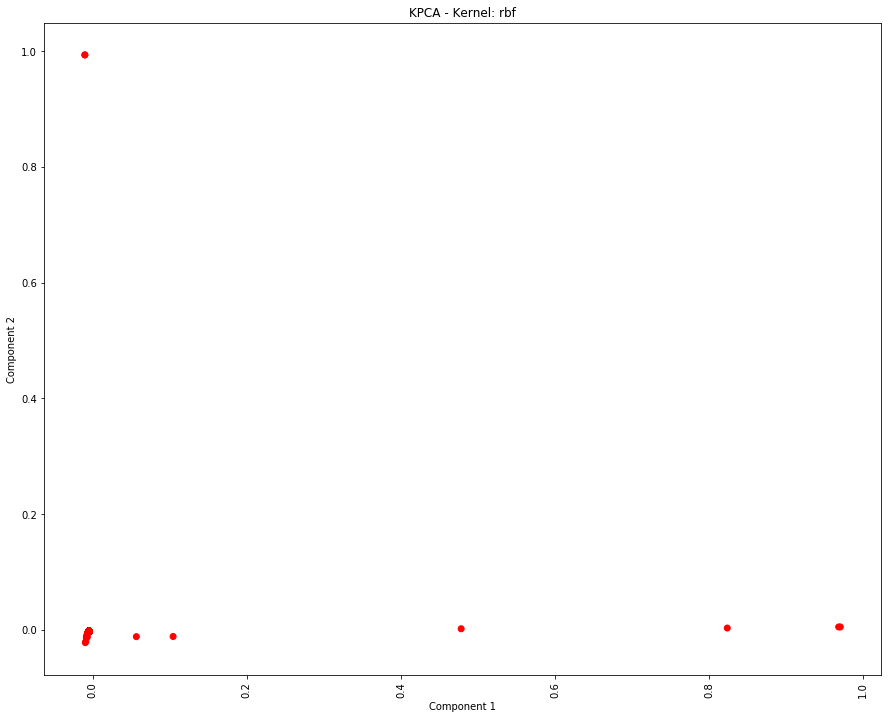

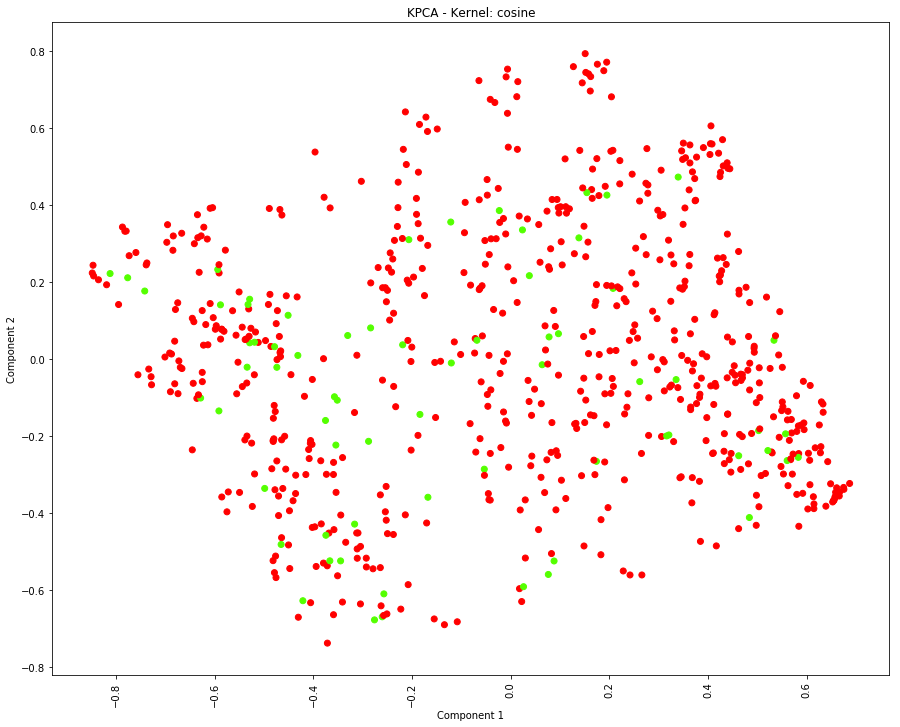

In [26]:
##############################
# Visualize Transformed Features
##############################

# set base parameters
pca_params = {'n_components': 2}
nmf_params = {'n_components': 2}
kpca_params = {
               'kernel': "rbf", 
               'gamma': 10,
               'degree': 3 # only for poly kernel
               }

# apply standard scaler to X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# display explained variance from PCA
pca.set_params(**pca_params)
pca.fit(X_scaled)
ind = np.arange(len(pca.explained_variance_ratio_))

plt.subplots()
plt.bar(ind, pca.explained_variance_ratio_)
plt.xticks(ind, rotation=90)
plt.title("PCA - Explain Variance Ratio")
plt.show()


# display results from PCA
pca_transformed = pca.transform(X)

plt.subplots(figsize=(15, 12))
plt.scatter(pca_transformed[:,0], pca_transformed[:,1], c=Y, cmap='prism', alpha=1)
plt.xticks(rotation=90)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA - 2 Component Visualization")
plt.show()


# apply minmax scaler to X
min_max_scaler = MinMaxScaler()
X_minmax_scaled = min_max_scaler.fit_transform(X)

# display results from NMF
nmf.set_params(**nmf_params)
nmf.fit(X_minmax_scaled)
nmf_transformed = nmf.transform(X_minmax_scaled)

plt.subplots(figsize=(15, 12))
plt.scatter(nmf_transformed[:,0], nmf_transformed[:,1], c=Y, cmap='prism', alpha=1)
plt.xticks(rotation=90)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("NMF - 2 Component Visualization")
plt.show()


# display results from KPCA
kpca_params = [{
               'kernel': "poly", 
               'gamma': 10,
               'degree': 3 # only for poly kernel
               },
               {
               'kernel': "poly", 
               'gamma': 10,
               'degree': 8 # only for poly kernel
               },
               {
               'kernel': "rbf", 
               'gamma': 10
               },
               {
               'kernel': "rbf", 
               'gamma': 50
               },
               {
               'kernel': "cosine"
               }]

for kpca_param in kpca_params:
    kpca.set_params(**kpca_param)
    kpca.fit(X_scaled)
    kpca_transformed = kpca.transform(X_scaled)

    plt.subplots(figsize=(15, 12))
    plt.scatter(kpca_transformed[:,0], kpca_transformed[:,1], c=Y, cmap='prism', alpha=1)
    plt.xticks(rotation=90)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("KPCA - Kernel: {}".format(kpca.get_params()['kernel']))
    plt.show()
